<a href="https://colab.research.google.com/github/patrickmineault/xcorr-notebooks/blob/master/PCA%2B_through_gradient_descent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unsupervised linear decompositions through gradient descent

Unsupervised deep learning can find latent nonlinear representations of complex datasets. However, the latent factors and their geometry may not be intrinsically meaningful, and care must be taken in interpreting what the latent factors mean. In scientific contexts, the latent factors are often intrinsically interesting. Hence, there remains considerable uses for classical dimensionality reduction methods (e.g. PCA, ICA, NMF, etc.) with simple generative models, where the role of the latent factors is clear. 

Here, I show that PCA, NMF, etc. can be implemented using stochastic gradient descent using PyTorch. While this is not very useful by itself (sklearn implements these models, after all), we can add exotic constraints and objective functions to obtain novel and powerful dimensionality reduction techniques. Automatic differentation allows us to write complexly structured models we could only dream about prior to the advent of deep learning.

To illustrate these concepts, I will analyze the Olivetti face dataset, [which has also been used as an example in scikit-learn](https://scikit-learn.org/stable/auto_examples/decomposition/plot_faces_decomposition.html). Let's get started.

## Good old PCA

Let's load up a face dataset and do PCA on it. We will find eigenfaces this way.


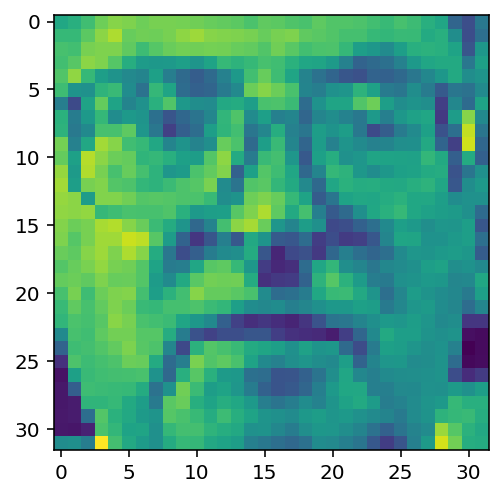

In [1]:
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces
from sklearn.cluster import MiniBatchKMeans
from sklearn import decomposition
import sklearn
import sklearn.cross_decomposition
import numpy as np
import seaborn as sns

rng = 10
faces, _ = fetch_olivetti_faces(return_X_y=True, shuffle=True,
                                random_state=rng)
# Downsample.
faces = faces.reshape((-1, 32, 2, 32, 2)).mean(axis=4).mean(axis=2).reshape((400, -1))
n_samples, n_features = faces.shape
n_components = 10
plt.imshow(faces[0, :].reshape((32, 32)))

Text(0.5, 0.98, '10 PCs of face dataset (eigenfaces)')

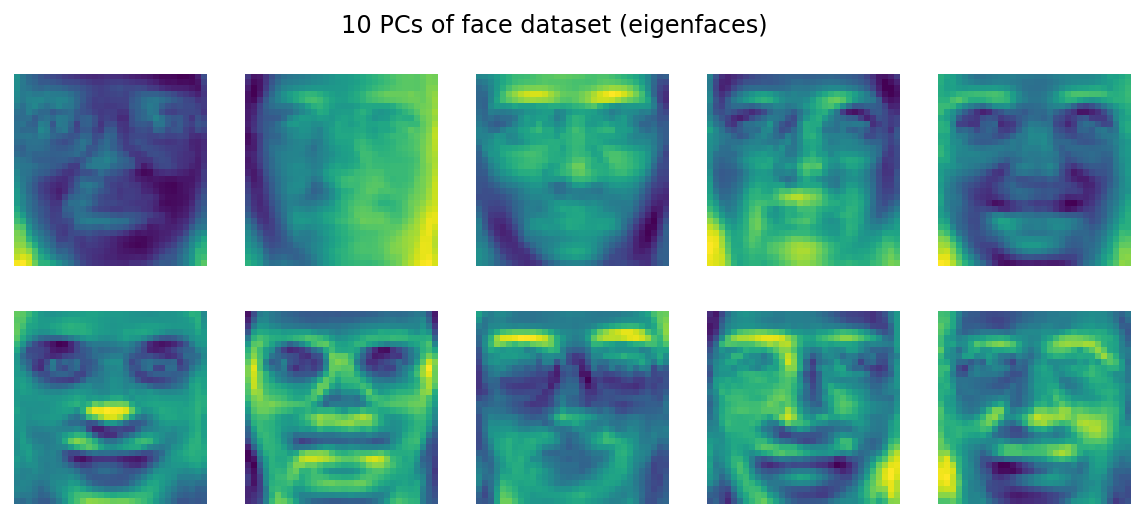

In [2]:
estimator = decomposition.PCA(n_components=n_components, svd_solver='randomized', whiten=True)
transformed = estimator.fit_transform(faces)
plt.figure(figsize=(10, 4))
for i in range(10):
  plt.subplot(2, 5, 1 + i)
  plt.imshow(estimator.components_[i, :].reshape((32, 32)))
  plt.axis('off')
plt.suptitle('10 PCs of face dataset (eigenfaces)')

# PCA via PyTorch

Could we instead do PCA with gradient descent? Yes. PCA's goal is to maximize the amount of variance accounted for by a truncated orthonormal decomposition. Formally, we approximate the matrix X by:

$$X \approx USV^T$$

Here $U$ and $V$ are orthonormal matrices, and $S$ is a diagonal matrix such that $S_{ii} >= S_{i+1,i+1}$. 

Let's minimize the sum-of-squares error between the model and its reconstruction. We'll push aside for the moment the gnarly issue of the relative ranking of the components and how to do reconstruction. We will factorize the matrix $X$ of faces as:

$$X \approx UV^T$$


In [3]:
import torch
from torch import optim
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset

class LinearReconstructionModel(nn.Module):
  def __init__(self, n_components, n_samples, n_features):
    super().__init__()
    self.n_components = n_components
    self.n_samples = n_samples
    self.n_features = n_features

    self.U = nn.Parameter(torch.randn(n_samples, n_components) / n_components)
    self.V = nn.Parameter(torch.randn(n_features, n_components) / n_components)

  def forward(self, idx):
    return self.U[idx, :] @ self.V.T

class ImageSet(Dataset):
  def __init__(self, X):
    self.X = X

  def __getitem__(self, i):
    return i, self.X[i, :]

  def __len__(self):
    return self.X.shape[0]

device = 'cuda'

model = LinearReconstructionModel(n_components, n_samples, n_features)
model.to(device=device)
faceset = ImageSet((faces - faces.mean(axis=0, keepdims=True)) / faces.std())
faceloader = torch.utils.data.DataLoader(faceset, batch_size=100, shuffle=True, num_workers=2)

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=100.0, momentum=0.9)

for epoch in range(50):  # loop over the dataset multiple times
  running_loss = 0.0
  U_before = model.U.detach().cpu().numpy().copy()
  for i, data in enumerate(faceloader, 0):
      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = model(inputs)
      loss = criterion(outputs, torch.tensor(labels).to(device=device))
      loss.backward()
      optimizer.step()

      # print statistics
      running_loss += loss.item()

  #print(((model.U.detach().cpu().numpy() - U_before) ** 2).mean())
  
  if epoch % 10 == 0:
    print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 10))
    running_loss = 0.0

print('Finished Training')

[1,     4] loss: 0.255


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[11,     4] loss: 0.099
[21,     4] loss: 0.087
[31,     4] loss: 0.081
[41,     4] loss: 0.080
Finished Training


Text(0.5, 0.98, '10 components of face dataset estimated through gradient descent')

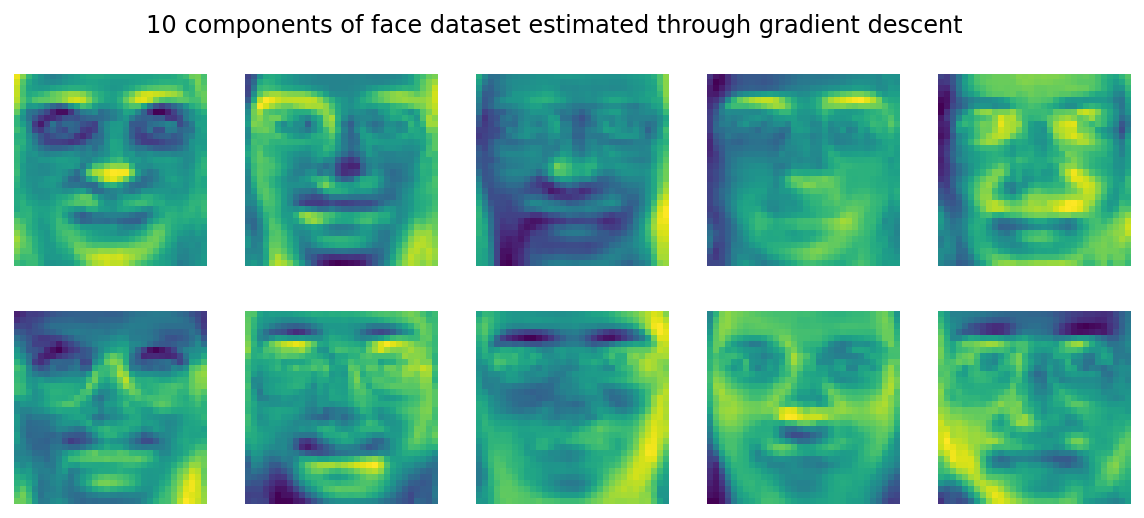

In [4]:
comps = model.V.detach().cpu().numpy().T
plt.figure(figsize=(10, 4))
for i in range(10):
  plt.subplot(2, 5, 1 + i)
  plt.imshow(comps[i, :].reshape((32, 32)))
  plt.axis('off')
plt.suptitle('10 components of face dataset estimated through gradient descent')

We note that the components look rotated compared to the PCs. Do they capture the same information, however? We can verify that they are indeed equivalent to the PCs using CCA.

Text(189.2400000000001, 0.5, 'Gradient descent-based components')

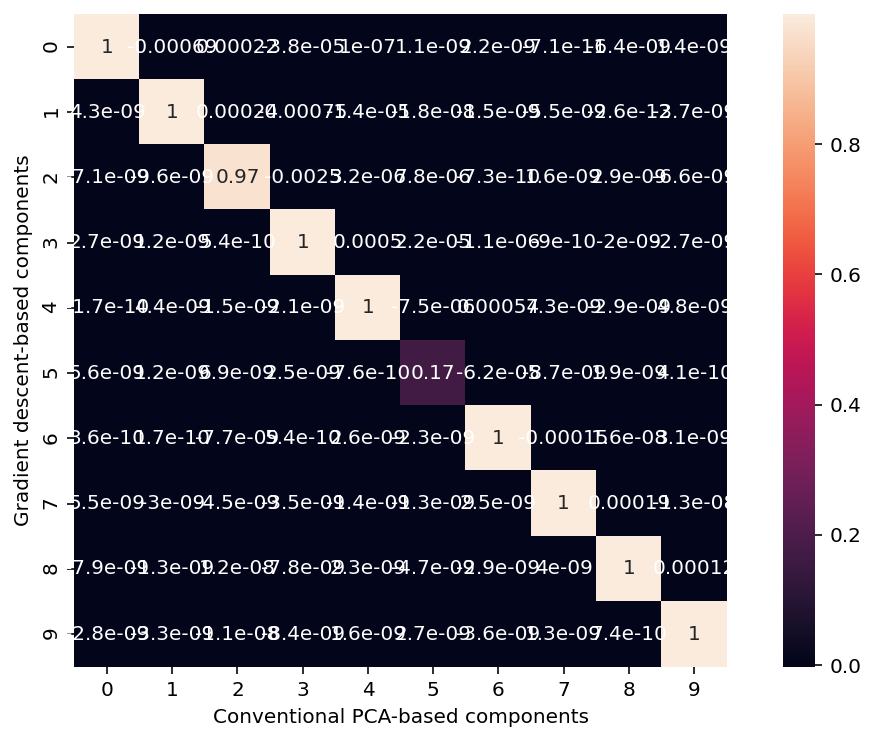

In [5]:
dec = sklearn.cross_decomposition.CCA(n_components=10)
dec.fit(estimator.components_.T, comps.T)
X_c, Y_c = dec.transform(estimator.components_.T, comps.T)

C = np.corrcoef(X_c.T, Y_c.T)
C = C[:, :10][10:, :]
plt.figure(figsize=(10, 6))
sns.heatmap(C, annot=True, square=True, ax=plt.gca())
plt.xlabel('Conventional PCA-based components')
plt.ylabel('Gradient descent-based components')

Indeed, our gradient-based PCA finds equivalent components to conventional PCA. How could we find the projection of another matrix $\hat{X}$ onto the components $V$? We will learn an amortized inference model to do so: 

* we freeze the model we've learned
* we present the amortizer pairs of data points and latent representations from the model
* we train the amortizer to map data points to latent representations

In the PCA case, the amortizer is linear; for nonlinear models, it could be more complex, of course.

In [6]:
class Amortizer(nn.Module):
  def __init__(self, n_components, n_samples, n_features):
    super().__init__()
    self.n_components = n_components
    self.n_samples = n_samples
    self.n_features = n_features

    self.W = nn.Parameter(torch.randn(n_features, n_components) / n_components)

  def forward(self, X):
    return X @ self.W

amortizer = Amortizer(n_components, n_samples, n_features)
amortizer.to(device=device)
faceset = ImageSet((faces - faces.mean(axis=0, keepdims=True)) / faces.std())
faceloader = torch.utils.data.DataLoader(faceset, batch_size=100, shuffle=True, num_workers=2)

criterion = nn.MSELoss()
optimizer = optim.SGD(amortizer.parameters(), lr=0.03, momentum=0.9)

for epoch in range(100):  # loop over the dataset multiple times
  running_loss = 0.0
  
  for i, data in enumerate(faceloader, 0):
      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = amortizer(torch.tensor(labels).to(device=device))
      loss = criterion(outputs, torch.tensor(model.U[inputs, :]).to(device=device))
      loss.backward()
      optimizer.step()

      # print statistics
      running_loss += loss.item()
  
  if epoch % 25 == 0:
    print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 10))
    running_loss = 0.0

print('Finished Training')

[1,     4] loss: 2.540


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[26,     4] loss: 0.027
[51,     4] loss: 0.012
[76,     4] loss: 0.007
Finished Training


And check that the amortizer indeed works.

In [7]:
_, data = faceset[:]
data = torch.tensor(data).to(device=device)
U_estimated = amortizer(data)
U_direct = data @ model.V @ torch.linalg.inv(model.V.T @ model.V)
R2 = 1 - ((U_estimated - model.U) ** 2).mean() / ((model.U - model.U.mean()) ** 2).mean()
print(R2)
R2_direct = 1 - ((U_direct - model.U) ** 2).mean() / ((model.U - model.U.mean()) ** 2).mean()
print(R2_direct)

tensor(0.9689, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.9992, device='cuda:0', grad_fn=<RsubBackward1>)


Thus, we've shown how we can learn a generative model that finds latent factors, and how to invert this generative model using amortized inference.

# NMF FTW

Cool! What else can we do with this? One idea is to fit non-negative components. The generative model is similar, but this time we disallow negative components for the V term. We can do this using a simple relu - but one problem we might run into is gradients not propagating. For this reason, we prefer a leaky relu. Let's do it!

In [8]:
class NNLinearReconstructionModel(nn.Module):
  def __init__(self, n_components, n_samples, n_features):
    super().__init__()
    self.n_components = n_components
    self.n_samples = n_samples
    self.n_features = n_features

    self.U = nn.Parameter(torch.randn(n_samples, n_components) / n_components)
    self.V = nn.Parameter(torch.randn(n_features, n_components) / n_components)

  def forward(self, idx):
    return self.U[idx, :] @ F.leaky_relu(self.V.T)

model = NNLinearReconstructionModel(n_components, n_samples, n_features)
model.to(device=device)
faceset = ImageSet((faces - faces.mean(axis=0, keepdims=True)) / faces.std())
faceloader = torch.utils.data.DataLoader(faceset, batch_size=100, shuffle=True, num_workers=2)

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=50.0, momentum=0.9)

for epoch in range(100):  # loop over the dataset multiple times
  running_loss = 0.0
  U_before = model.U.detach().cpu().numpy().copy()
  for i, data in enumerate(faceloader, 0):
      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = model(inputs)
      loss = criterion(outputs, torch.tensor(labels).to(device=device))
      loss.backward()
      optimizer.step()

      # print statistics
      running_loss += loss.item()

  #print(((model.U.detach().cpu().numpy() - U_before) ** 2).mean())
  
  if epoch % 10 == 0:
    print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 10))
    running_loss = 0.0

print('Finished Training')

[1,     4] loss: 0.254


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[11,     4] loss: 0.152
[21,     4] loss: 0.125
[31,     4] loss: 0.115
[41,     4] loss: 0.109
[51,     4] loss: 0.105
[61,     4] loss: 0.102
[71,     4] loss: 0.099
[81,     4] loss: 0.097
[91,     4] loss: 0.095
Finished Training


Text(0.5, 0.98, '10 components of face dataset estimated through gradient descent')

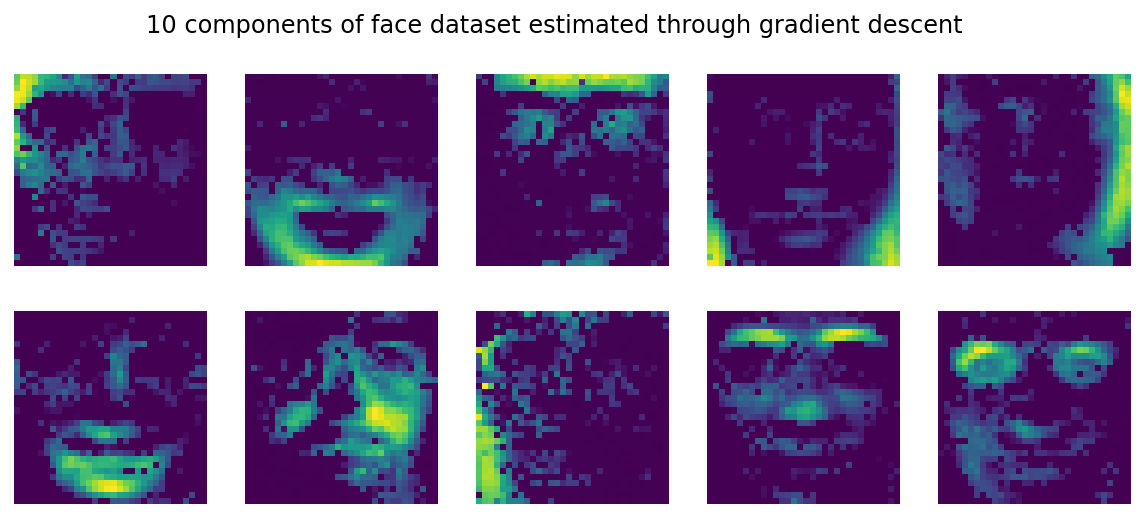

In [9]:
comps = F.leaky_relu(model.V).detach().cpu().numpy().T
plt.figure(figsize=(10, 4))
for i in range(10):
  plt.subplot(2, 5, 1 + i)
  plt.imshow(comps[i, :].reshape((32, 32)))
  plt.axis('off')
plt.suptitle('10 components of face dataset estimated through gradient descent')

Very cool! We find a parts based decomposition - eyebrows and eyes are easy to see. This is consistent with what the know about NMF on face datasets - see e.g. [Lee & Seung (1999)](https://www.nature.com/articles/44565).

# Localized parametrization

So far we haven't done anything that we couldn't achieve with sklearn - and it cost us some complexity. But gradient descent-based parametrizations can allow us to parametrize funky generative models quite easily. Here's one example here where we learn localized, non-negative representations. It's as sample as adding an appropriate penalty.

In [10]:
class NNLinearReconstructionModel(nn.Module):
  def __init__(self, n_components, n_samples, n_features):
    super().__init__()
    self.n_components = n_components
    self.n_samples = n_samples
    self.n_features = n_features

    self.U = nn.Parameter(torch.randn(n_samples, n_components) / n_components)
    self.V = nn.Parameter(torch.randn(n_features, n_components) / n_components)

  def forward(self, idx):
    return self.U[idx, :] @ F.leaky_relu(self.V.T)

xi, yi = torch.meshgrid(torch.arange(32), torch.arange(32))
xi = xi.to(device=device).reshape(-1, 1)
yi = yi.to(device=device).reshape(-1, 1)

def penalty(model):
  V = F.relu(model.V)
  x0 = (V * xi).sum(axis=0) / V.sum(axis=0)
  y0 = (V * yi).sum(axis=0) / V.sum(axis=0)
  E = ((V * (xi - x0) ** 2).sum(axis=0) + 
       (V * (yi - y0) ** 2).sum(axis=0)).sum()
  
  return E * 1E-6

model = NNLinearReconstructionModel(n_components, n_samples, n_features)
model.to(device=device)
faceset = ImageSet((faces - faces.mean(axis=0, keepdims=True)) / faces.std())
faceloader = torch.utils.data.DataLoader(faceset, batch_size=100, shuffle=True, num_workers=2)

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=50.0, momentum=0.9)

for epoch in range(300):  # loop over the dataset multiple times
  running_loss = 0.0
  U_before = model.U.detach().cpu().numpy().copy()
  for i, data in enumerate(faceloader, 0):
      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = model(inputs)
      loss = criterion(outputs, torch.tensor(labels).to(device=device)) + penalty(model)
      loss.backward()
      optimizer.step()

      # print statistics
      running_loss += loss.item()

  #print(((model.U.detach().cpu().numpy() - U_before) ** 2).mean())
  
  if epoch % 30 == 0:
    print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 10))
    running_loss = 0.0

print('Finished Training')

[1,     4] loss: 0.274


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[31,     4] loss: 0.164
[61,     4] loss: 0.127
[91,     4] loss: 0.114
[121,     4] loss: 0.110
[151,     4] loss: 0.107
[181,     4] loss: 0.106
[211,     4] loss: 0.105
[241,     4] loss: 0.105
[271,     4] loss: 0.105
Finished Training


Text(0.5, 0.98, '10 components of face dataset estimated through gradient descent')

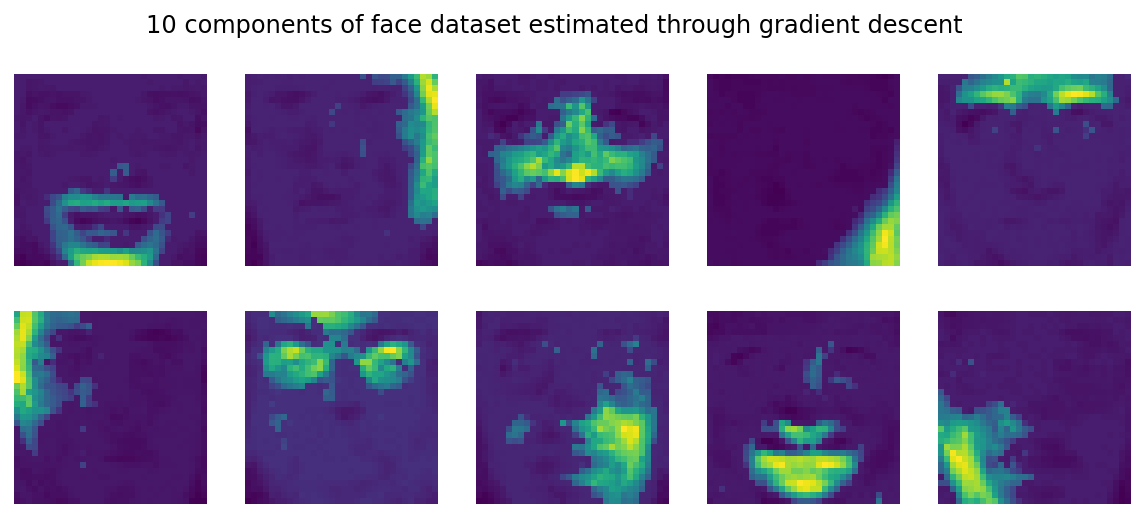

In [11]:
comps = F.leaky_relu(model.V).detach().cpu().numpy().T
plt.figure(figsize=(10, 4))
for i in range(10):
  plt.subplot(2, 5, 1 + i)
  plt.imshow(comps[i, :].reshape((32, 32)))
  plt.axis('off')
plt.suptitle('10 components of face dataset estimated through gradient descent')

Notice the representations are far more localized than in the previous section.